# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation. 

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pygame

# Instantiate a rendering and a non-rendering environment.
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

In [2]:
import wandb

# Inizializza Weights & Biases
wandb.init(project="reinforce-cartpole", name="policy_gradient_run")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: marco-digesare (marco-digesare-university-of-florence) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [38]:
(obs, info) = env.reset()
env.action_space # return the action space of the environment

Discrete(2)

In [39]:
env.observation_space # return the observation space of the environment

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

In [40]:
# at first we reset to the middle the pendulum position and add noise (it makes the pendulum swing a bit)
obs # print the observation

array([ 0.04441478, -0.04412647,  0.04048895, -0.03495523], dtype=float32)

In [41]:
env.spec.pprint() # print the environment specification

id=CartPole-v1
reward_threshold=475.0
max_episode_steps=500


In [42]:
# policy network
class PolicyNet(nn.Module):
    def __init__(self, env):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc3 = nn.Linear(128, env.action_space.n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc3(x), dim=-1)

In [21]:
# reinforce algorithm
class Reinforce:
    def __init__(self, policy, env, gamma=0.99, num_episodes=10):
        self.policy = policy
        self.env = env
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.opt = optim.Adam(policy.parameters(), lr=1e-2) # Adam optimizer

    def run_episode(self):
        obs, info = self.env.reset()
        rewards = []
        log_probs = []
        actions = []

        done = False
        while not done:
            action_probs = self.policy(torch.tensor(obs, dtype=torch.float32))
            action = torch.multinomial(action_probs, 1).item()
            log_prob = torch.log(action_probs[action])

            obs, reward, terminated, truncated, info = self.env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            actions.append(action)

            done = terminated or truncated

        return rewards, log_probs, actions

In [23]:
# example of running an episode
policy = PolicyNet(env)
reinforce = Reinforce(policy, env)
for i in range(10):
    # run an episode
    rewards, log_probs, actions = reinforce.run_episode()
    print(f"Episode {i+1}: Total Reward: {sum(rewards)}")


Episode 1: Total Reward: 11.0
Episode 2: Total Reward: 34.0
Episode 3: Total Reward: 16.0
Episode 4: Total Reward: 31.0
Episode 5: Total Reward: 14.0
Episode 6: Total Reward: 15.0
Episode 7: Total Reward: 10.0
Episode 8: Total Reward: 22.0
Episode 9: Total Reward: 29.0
Episode 10: Total Reward: 15.0


In [3]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy): # obs and policy are torch tensors
    dist = Categorical(policy(obs)) # sample from the policy
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1)) # return the selected action and the log_prob of that action

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy() # from an input list of rewards and a discount factor gamma, compute the discounted returns

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500): # maxlen is the maximum number of steps of the episode
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []

    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs) # observe the environment and convert the observation to a tensor
        (action, log_prob) = select_action(env, obs, policy) # select an action from the policy
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)

        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action) # go to the next step in the environment, term is True if the episode is over, trunc is True if the episode was truncated
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards) # return the observations, actions, log_probs and rewards of the episode

In [4]:
# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module): # use a deep neural network to represent the policy
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, env.action_space.n)

    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s), dim=-1)
        return s

In [5]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=10):
    # The only non-vanilla part: we use Adam instead of SGD.
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)

    # Track episode rewards in a list.
    running_rewards = [0.0] # collect the running rewards of the episodes

    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        # Run an episode of the environment, collect everything needed for policy update.
        (observations, actions, log_probs, rewards) = run_episode(env, policy)

        # Compute the discounted reward for every step of the episode.
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)

        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        # Standardize returns.
        returns = (returns - returns.mean()) / returns.std() # standardize the returns, stabilizing the training

        # Make an optimization step
        opt.zero_grad()
        loss = (-log_probs * returns).mean() # mean instead of sum to make the learning rate independent of the number of steps in the episode
        loss.backward()
        opt.step()

        # Render an episode after every 100 policy updates.
        if not episode % 100:
            if env_render:
                policy.eval()
                run_episode(env_render, policy)
                policy.train()
            print(f'Running reward: {running_rewards[-1]}')

    # Return the running rewards.
    policy.eval()
    return running_rewards

In [69]:
# Reinforce with W&B
def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=10):
    opt = torch.optim.Adam(policy.parameters(), lr=1e-2)
    running_rewards = [0.0]

    policy.train()
    for episode in range(num_episodes):
        observations, actions, log_probs, rewards = run_episode(env, policy)
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)

        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        opt.zero_grad()
        loss = (-log_probs * returns).mean()
        loss.backward()
        opt.step()

        # Log su wandb
        wandb.log({
            "episode": episode,
            "loss": loss.item(),
            "reward": returns[0].item(),
            "running_reward": running_rewards[-1]
        })

        if episode % 100 == 0:
            if env_render:
                policy.eval()
                run_episode(env_render, policy)
                policy.train()
            print(f'Running reward: {running_rewards[-1]}')

    policy.eval()
    return running_rewards

In [6]:
# Instantiate a (rendering) CartPole environment.
env_render = gym.make('CartPole-v1', render_mode='human')
pygame.display.init()  # Might help PyGame not crash...

# Make a policy network and run a few episodes to see how well random initialization works.
policy = PolicyNet(env_render)
for _ in range(10):
    run_episode(env_render, policy)

# If you don't close the environment, the PyGame window stays visible.
env_render.close()

# Again we pray PyGame doesn't crash...
pygame.display.quit()

Running reward: 0.7352840423583985
Running reward: 49.96331935858296
Running reward: 62.199887457454466
Running reward: 83.76816105347082
Running reward: 96.37891060354198


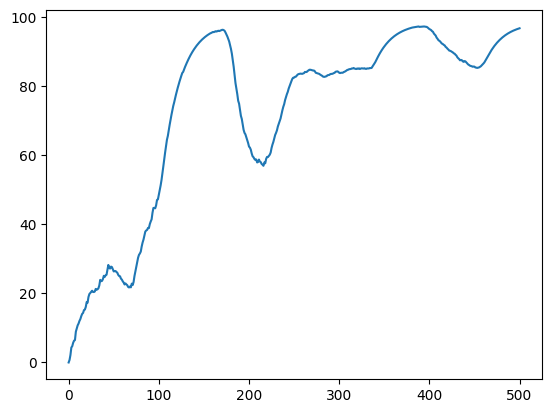

In [7]:
# In the new version of Gymnasium you need different environments for rendering and no rendering.
# Here we instantiate two versions of cartpole, one that animates the episodes (which slows everything
# down), and another that does not animate.
seed = 2112
torch.manual_seed(seed)
np.random.seed(seed)

env = gym.make('CartPole-v1')
env.reset(seed=seed)
env_render = None # gymnasium.make('CartPole-v1', render_mode='human')

# PyGame, please don't crash.
pygame.display.init()

# Make a policy network.
policy = PolicyNet(env)

# Train the agent.
plt.plot(reinforce(policy, env, env_render, num_episodes=500))

# Close up everything
#env_render.close()
env.close()
pygame.display.quit()  # Fingers crossed...

In [ ]:
# log of episode_return and episode_length (optional avg_val_length) to make weights and biases plots. episode_return is the total reward of the episode, episode_length is the number of steps in the episode, avg_val_length is the average length of the episodes. Also loss is logged, it's a good metric to see if the agent is learning or not.
# at the beginning the loss is low because the agent is not learning, then it increases because the agent is learning. The loss is not a good metric to see if the agent is learning or not, but it's a good metric to see if the agent is overfitting or not. The loss should be low and stable, if it increases too much the agent is overfitting. If it decreases too much the agent is underfitting. The loss should be low and stable, if it increases too much the agent is overfitting. If it decreases too much the agent is underfitting.

# vectorized environment is used to parallelize the training of the agent. It is not used in this implementation, but it is a good practice to use it when training agents in reinforcement learning.
# No baseline Vs standardized baseline Vs value function baseline

# I need a second network to estimate the value function with input = state s and output = v(s). 4 elements in the input vector, 1 element in the output vector. The second network has the same architecture of the policy network. (the last layer changes from 2 to 1)
# The output of the second network is used as a baseline in the REINFORCE algorithm.
# Gt is a sample of the return of the episode, the second network has to be trained to learn (V(s) - Gt)^alpha

In [9]:
# Your code here. Call .reset() on the environment and inspect the output. Also, check out the observation_space.

**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here. 

In [36]:
# Your code here. You should be able to train an agent to solve Cartpole. This will be our starting point.

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

In [ ]:
# Your code here.

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

In [1]:
# Your code here. Modify your implementation of `REINFORCE` to optionally use the standardize baseline.

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**. 

In [2]:
# Your code here.

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

 